<a href="https://colab.research.google.com/github/PatrickChrist/applied-ai/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Libraries**

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


ModuleNotFoundError: ignored

## **Loading Our Dataset**

In [2]:
from google.colab import files

In [53]:
!pip install yfinance
import yfinance as yf

#Interval required 1 minute
stock_data = yf.download(tickers='BMW.de', period='max', interval='1d')
df = stock_data
stock_data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-11-08,18.209999,18.209999,18.171000,18.171000,10.041771,767000
1996-11-11,18.190001,18.200001,18.082001,18.122000,10.014695,260000
1996-11-12,18.160999,18.327999,18.091999,18.259001,10.090405,1066000
1996-11-13,18.344000,18.344000,18.190001,18.230000,10.074377,793000
1996-11-14,18.205000,18.289000,18.132000,18.289000,10.106983,351000
...,...,...,...,...,...,...
2021-06-01,87.669998,89.360001,87.669998,89.010002,89.010002,1163996
2021-06-02,89.220001,90.639999,88.830002,90.300003,90.300003,1217637
2021-06-03,90.500000,94.199997,90.370003,93.870003,93.870003,1908125


## **Feature Extraction**

 The number of the trading days and the columns: 

In [32]:
df.shape

(6299, 6)

In [33]:
df = df['Open'].values
df = df.reshape(-1, 1)

After extracting one column:


In [34]:
df.shape

(6299, 1)

In [35]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8):])
print(dataset_train.shape)
print(dataset_test.shape)

(5039, 1)
(1260, 1)


Importing our model:

In [36]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

Scaling data:

In [37]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.00877191],
       [0.00858328],
       [0.00830974],
       [0.01003583],
       [0.00872476]])

In [38]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:5]

array([[0.47453306],
       [0.48849272],
       [0.50839463],
       [0.5189587 ],
       [0.52735333]])

In [39]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y 

Creating training and testing datasets:

In [40]:
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [108]:
print(x_train.shape,y_train.shape)

(4989, 50, 1) (4989,)


Creating our LSTM model:

In [41]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

Reshape features for the LSTM layer:

In [42]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [43]:
model.compile(loss='mean_squared_error', optimizer='adam')

Start the training:

In [44]:
model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('stock_prediction.h5')

Epoch 1/50
156/156 [==============================] - 32s 158ms/step - loss: 0.0120
Epoch 2/50
156/156 [==============================] - 25s 160ms/step - loss: 0.0015
Epoch 3/50
156/156 [==============================] - 25s 159ms/step - loss: 0.0014
Epoch 4/50
156/156 [==============================] - 25s 159ms/step - loss: 0.0013
Epoch 5/50
156/156 [==============================] - 25s 159ms/step - loss: 0.0011
Epoch 6/50
156/156 [==============================] - 25s 159ms/step - loss: 0.0011
Epoch 7/50
156/156 [==============================] - 25s 159ms/step - loss: 9.4328e-04
Epoch 8/50
156/156 [==============================] - 25s 160ms/step - loss: 8.5193e-04
Epoch 9/50
156/156 [==============================] - 25s 160ms/step - loss: 8.9138e-04
Epoch 10/50
156/156 [==============================] - 25s 159ms/step - loss: 7.5752e-04
Epoch 11/50
156/156 [==============================] - 25s 159ms/step - loss: 7.3882e-04
Epoch 12/50
156/156 [==============================] -

In [101]:
model = load_model('stock_prediction.h5')

## **Results visualization**

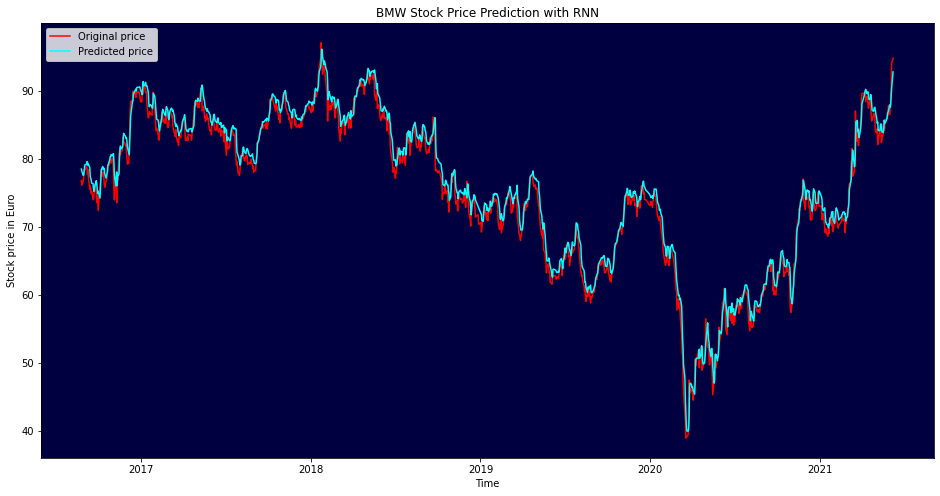

In [102]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Set the right time on the x axis
x_t = stock_data.index[int(stock_data.index.shape[0]*0.8):]
x_t = x_t[50:]
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(x_t, y_test_scaled, color='red', label='Original price')

plt.plot(x_t, predictions, color='cyan', label='Predicted price')
plt.ylabel("Stock price in Euro")
plt.xlabel("Time")
plt.title("BMW Stock Price Prediction with RNN")
plt.legend()

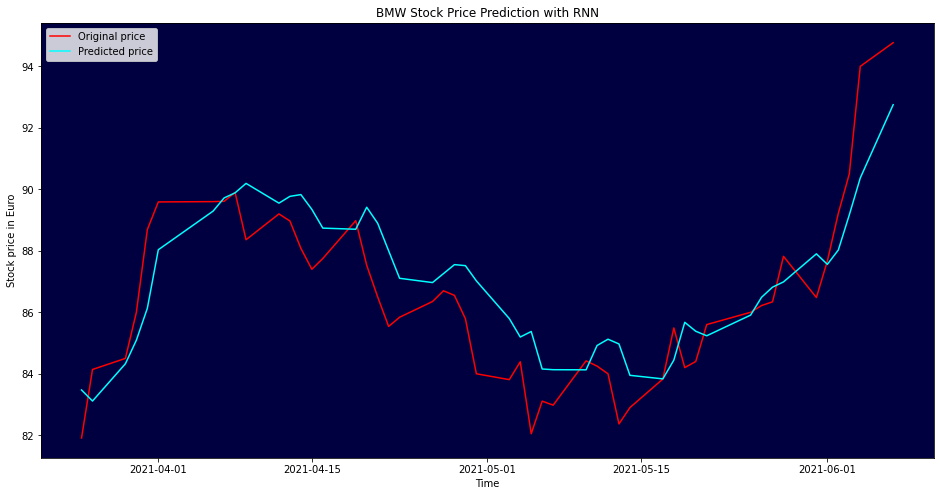

In [104]:
## Predicting the price of the next 50 days
predictions = model.predict(x_test[-50:])
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Set the right time on the x axis
x_t = stock_data.index[int(stock_data.index.shape[0]*0.8):]
x_t = x_t[50:]
x_t=x_t[-50:]
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(x_t[-50:], y_test_scaled[-50:], color='red', label='Original price')

plt.plot(x_t[-50:], predictions[-50:], color='cyan', label='Predicted price')
plt.ylabel("Stock price in Euro")
plt.xlabel("Time")
plt.title("BMW Stock Price Prediction with RNN")
plt.legend()

# Homework 1: Predict Covid 19 Incidence in Bavaria with RNNs

In [90]:
# Downloading Data of Covid 19 cases in Bavaria

covid_data = pd.read_csv("https://raw.githubusercontent.com/jgehrcke/covid-19-germany-gae/master/cases-rki-by-state.csv")
covid_data

,time_iso8601,DE-BB,DE-BE,DE-BW,DE-BY,DE-HB,DE-HE,DE-HH,DE-MV,DE-NI,DE-NW,DE-RP,DE-SH,DE-SL,DE-SN,DE-ST,DE-TH,sum_cases
0,2020-03-02T17:00:00+0000,2,0,30,34,2,9,2,0,4,116,2,4,3,1,0,0,209
1,2020-03-03T17:00:00+0000,2,6,54,40,4,13,5,2,10,145,3,5,3,1,0,1,294
2,2020-03-04T17:00:00+0000,2,9,92,50,4,15,6,4,14,235,7,5,3,1,0,1,448
3,2020-03-05T17:00:00+0000,4,19,128,69,4,21,11,5,20,332,8,6,3,1,0,1,632
4,2020-03-06T17:00:00+0000,4,24,179,120,4,22,14,5,27,394,10,8,3,3,0,1,818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,2021-06-02T17:00:00+0000,108414,178746,494269,641135,27153,287644,76454,43936,258939,808181,153363,63242,40937,284508,98684,127854,3693459
458,2021-06-03T17:00:00+0000,108472,178965,494776,641542,27193,287927,76518,43949,259167,808797,153504,63286,40981,284640,98745,127942,3696404
459,2021-06-04T17:00:00+0000,108514,179097,494922,641862,27218,288055,76574,43971,259304,809401,153641,63337,41003,284760,98792,128045,3698496
460,2021-06-05T17:00:00+0000,108538,179119,495303,642312,27237,288271,76598,43987,259429,809876,153760,63377,41036,284866,98848,128125,3700682


# Homework 2: Adjust the network depth. What effect are you encountering?

In [107]:
x_test.shape

(1210, 50, 1)